# <center>CITS5017 Project 2<center>
<center>Allison Lau (23123849)<center>

# Import packages

In [1]:
import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Load and Prepare Data
- `PerthA_df`: temperature data from 1944-06 to 2024-08 (total 963 months)
- `PerthM_df`: temperature data from 1994-01 to 2024-08 (total 368 months)

In [2]:
# load the data from the pickle file
def load_data(picklefile):
    f = open(picklefile, "rb")
    dict = pickle.load(f)
    f.close()
    return dict["Perth_Airport"], dict["Perth_Metro"]

# split the data into inputs and targets
def split_data(df, inputs_length, targets_length, batch_size=32, shuffle=True, seed=42):
    # an inner function to do the splitting
    def split_inputs_and_targets(tf_ds):
        return tf_ds[:, :-targets_length], tf_ds[:, -targets_length:]

    if batch_size == -1:
        batch_size = df.shape[0]

    return tf.keras.utils.timeseries_dataset_from_array(
                tf.convert_to_tensor(df, dtype=tf.float32),
                targets = None,
                sequence_length = inputs_length + targets_length,
                batch_size = batch_size,
                shuffle = shuffle,
                seed = seed
            ).map(split_inputs_and_targets)

# Load data and display length
PerthA_df, PerthM_df = load_data("temperatures.pkl")
print(f"Total Perth Airport data: {len(PerthA_df)}")
print(f"Total Perth Metro data: {len(PerthM_df)}")

Total Perth Airport data: 963
Total Perth Metro data: 368


# Part 1 Tasks
Implement three algorithms for predicting the minimum and maximum temperatures and compare their performances.

## (a) Get training, validation, and test datasets
- **Training data**: `PerthA_df`
- **Validation data**: `PerthM_df` from 1994-01 to 2013-12
- **Test data**: `PerthM_df` from 2014-01 onward

In [3]:
# Split data depending on the length of the sequences
def split_data_length(df, seq_lengths, train=False):
    inputs_length, targets_length = (seq_lengths)
    if train:
        ds = split_data(df, inputs_length, targets_length, batch_size=32, shuffle=True)
    else:
        ds = split_data(df, inputs_length, targets_length, batch_size=-1, shuffle=False)
    return ds

# Separate into validation and test datasets
PerthM_val = PerthM_df.loc["1994-01":"2013-12"] # First 20 years
PerthM_test = PerthM_df.loc["2014-01":]         # Last 10 years

# Split into training, validation and test datasets
train_ds = split_data_length(PerthA_df, (72, 12), train=True)
val_ds = split_data_length(PerthM_val, (72, 12))
test_ds = split_data_length(PerthM_test, (72, 12))

for batch in test_ds.take(1):
    X_test, y_test = batch

## (b) `display_temperatures` function
- Display the minimum and maximum temperatures for 3 random samples in 1 x 3 subplots
- Plot the input sequence, target sequence, (and predicted sequence if available)

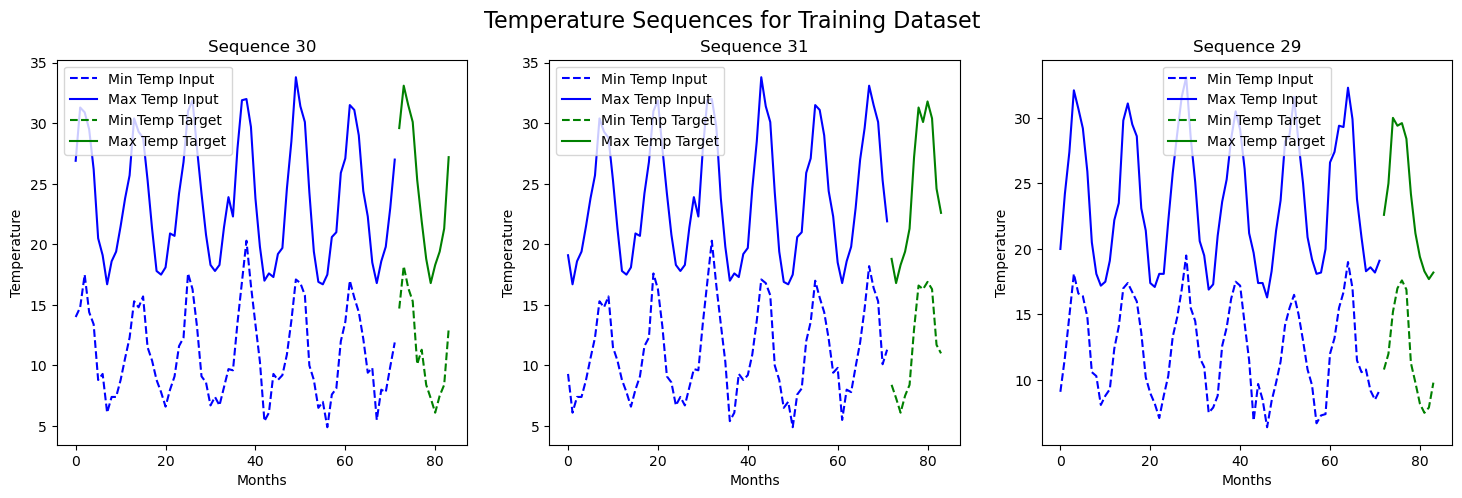

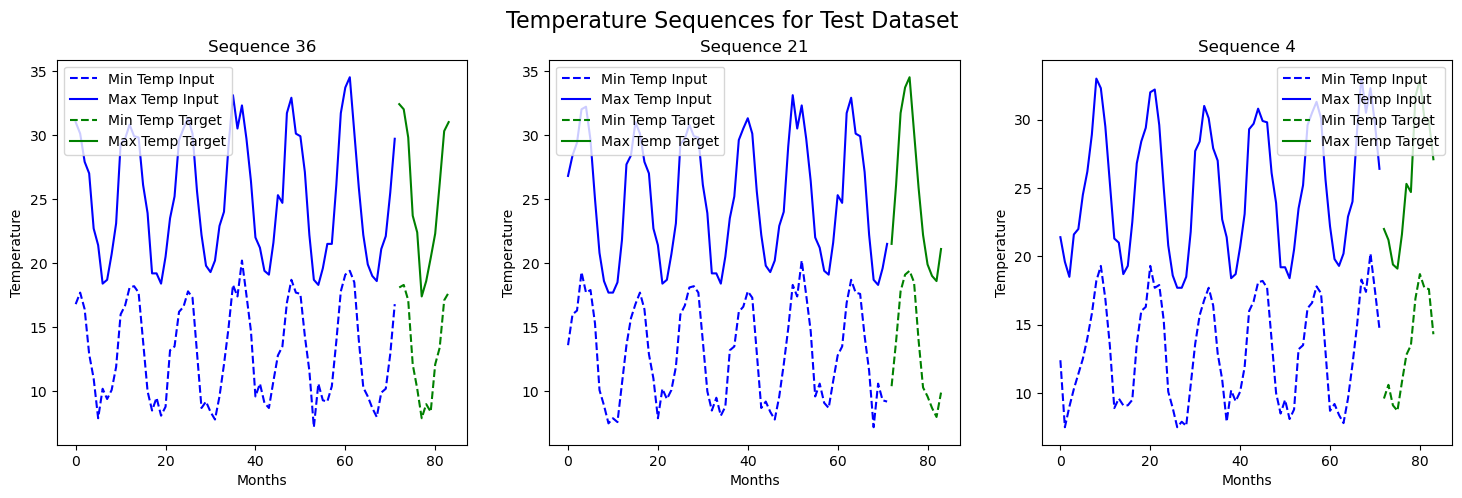

In [4]:
# Function to display 3 samples of temperature sequences (max and min)
def display_temperatures(input, target, indices, pred=None, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Temperature Sequences for {title}', fontsize=16)

    for i, idx in enumerate(indices):
        input_length = input.shape[1]
        target_length = target.shape[1]
        input_range = range(0, input_length)
        target_range = range(input_length, input_length+target_length)
        # min temp sequence in column 0, max temp sequence in column 1
        input_min = input[idx, :, 0]
        input_max = input[idx, :, 1]
        target_min = target[idx, :, 0]
        target_max = target[idx, :, 1]
        axes[i].plot(input_range, input_min, label="Min Temp Input", color='blue', linestyle='--')
        axes[i].plot(input_range, input_max, label="Max Temp Input", color='blue', linestyle='-')
        axes[i].plot(target_range, target_min, label="Min Temp Target", color='green', linestyle='--')
        axes[i].plot(target_range, target_max, label="Max Temp Target", color='green', linestyle='-')
        
        if pred is not None:
            pred_min = pred[idx, :, 0]
            pred_max = pred[idx, :, 1]
            axes[i].plot(target_range, pred_min, label="Min Temp Prediction", color='red', linestyle='--')
            axes[i].plot(target_range, pred_max, label="Max Temp Prediction", color='red', linestyle='-')
        
        axes[i].set_title(f"Sequence {idx}")
        axes[i].set_xlabel("Months")
        axes[i].set_ylabel("Temperature")
        axes[i].legend()

# Display 3 random sequences from the training dataset
for batch in train_ds.take(1):
    X_train, y_train = batch
    train_indices = random.sample(range(X_train.shape[0]), 3)
    display_temperatures(X_train, y_train, train_indices, title="Training Dataset")

# Display 3 random sequences from the test dataset
test_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, test_indices, title="Test Dataset")

## (c) Model 1

### Functions (Model, Training, and Evaluation)
- `create_gru()`: create 2-layer GRU model with 16 units each (activation function used is `ReLU` to prevent vanishing gradients)
- `train_model()`: train model for 50 epochs (no verbose)
- `plot_learning_curves()`: plot learning curves for training and validation datasets (metric of interest is MAE)
- `compute_mae()`: compute MAE for the test dataset

In [5]:
# Create 2-layer GRU model with 16 units
def create_gru(input_shape, output_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(16, activation='relu', return_sequences=True),
        layers.GRU(16, activation='relu'),
        layers.Dense(output_shape[0] * output_shape[1]),
        layers.Reshape(output_shape)
    ])
    return model

# Train GRU model
def train_model(model, train_ds, val_ds, epochs=50, verbose=0):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=verbose)
    return history

# Plot learning curves (metric of interest MAE)
def plot_learning_curves(history, title):
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{title} Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()
    
# Calculate MAE between test targets and predictions
def compute_mae(y_test, y_pred, model_name=""):
    test_mae = np.mean(np.abs(y_pred - y_test))
    print(f"{model_name} Test MAE: {test_mae:.2f}")
    return test_mae

### Train Model 1
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Output sequence**: 12 months of minimum and maximum temperatures

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 72, 16)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 12, 2)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000 (11.72 KB)

 Trainable params: 3,000 (11.72 KB)

 Non-trainable params: 0 (0.00 B)

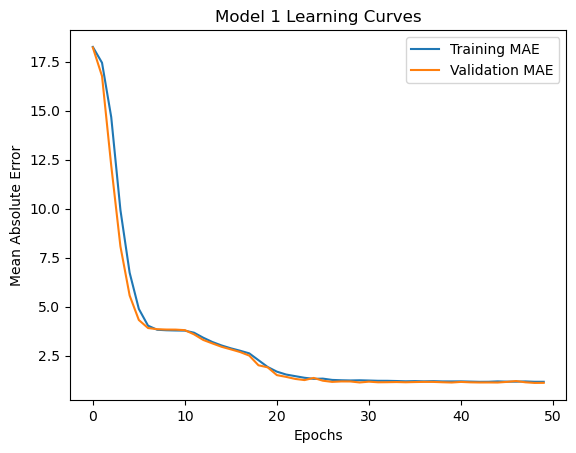

In [6]:
# Model 1: input shape (72, 2) -> output shape (12, 2)
# Create and display model 1
model1 = create_gru(input_shape=(72, 2), output_shape=(12, 2))
model1.summary()

# Train model 1 and plot learning curves
history1 = train_model(model1, train_ds, val_ds)
plot_learning_curves(history1, "Model 1")

### Evaluate Model 1
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Output sequence**: 12 months of minimum and maximum temperatures

Model 1 Test MAE: 1.25


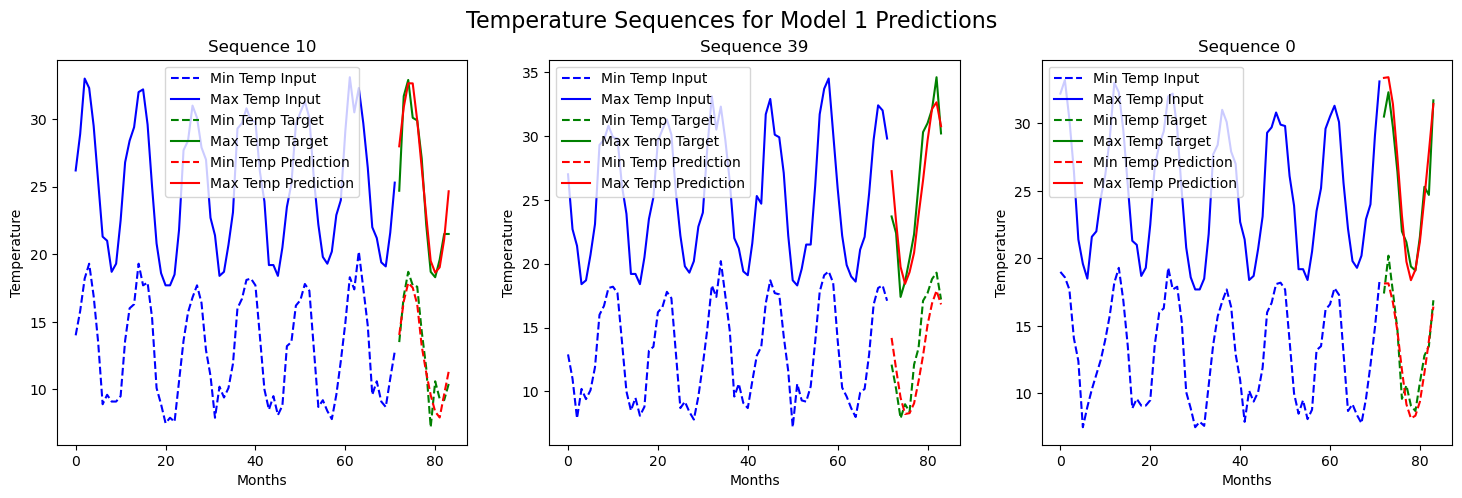

In [7]:
# Function to evaluate model 1 on the test dataset
def evaluate_model1(model, test_ds):
    _, test_mae = model.evaluate(test_ds, verbose=0)
    print(f"Model 1 Test MAE: {test_mae:.2f}")
    return test_mae

# Evaluate model 1 on the test dataset
y_pred = model1.predict(X_test, verbose=0)
mae1 = evaluate_model1(model1, test_ds)

# Display 3 random sequences with predictions
sample_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, sample_indices, y_pred, title="Model 1 Predictions")

## (d) Model 2

### Train Model 2
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Output sequence**: 1 months of minimum and maximum temperatures

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 72, 16)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626 (10.26 KB)

 Trainable params: 2,626 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

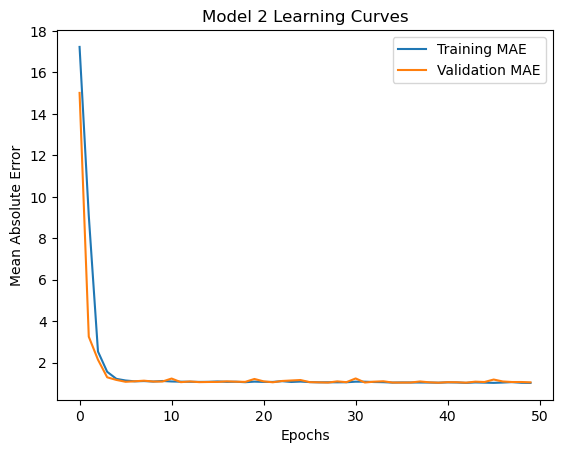

In [8]:
# Model 2: input shape (72, 2) -> output shape (1, 2)
# Split data for model 2 (output shape 1)
train_ds_output1 = split_data_length(PerthA_df, (72, 1), train=True)
val_ds_output1 = split_data_length(PerthM_val, (72, 1))

# Create and display model 2
model2 = create_gru(input_shape=(72, 2), output_shape=(1, 2))
model2.summary()

# Train model 2 and plot learning curves
history2 = train_model(model2, train_ds_output1, val_ds_output1)
plot_learning_curves(history2, "Model 2")

### Evaluate Model 2
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Output sequence**: 12 months of minimum and maximum temperatures (predicted 1 month at a time)

 Test MAE: 1.30


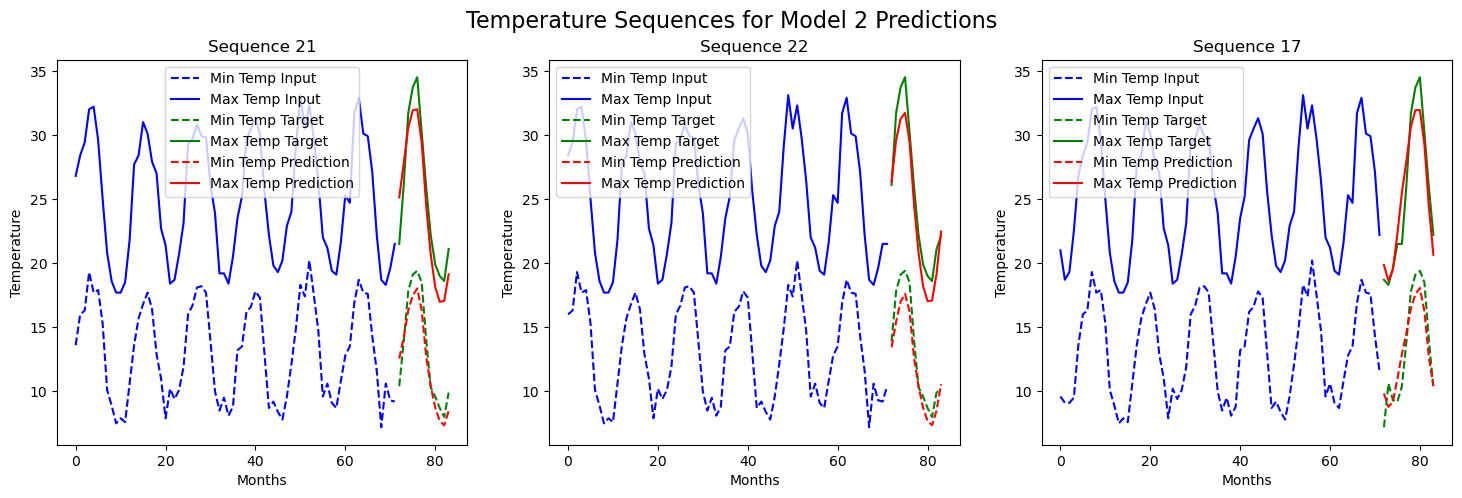

In [9]:
# Function to predict the next n months (1 at a time) for model 2
def predict_months(model, input_X, steps=12):
    X = input_X
    for step in range(steps):
        y_pred_one = model.predict(X[:, step:], verbose=0)
        X = np.concatenate([X, y_pred_one], axis=1)
    y_pred = X[:, -steps:, :]
    return np.array(y_pred)
    
# Evaluate model 2 on the test dataset
y_pred = predict_months(model2, X_test)
mae2 = compute_mae(y_test, y_pred)

# Display 3 random sequences with predictions
sample_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, sample_indices, y_pred, title="Model 2 Predictions")

## (e) Model 3

### Prepare Datasets for Model 3 Training and Evaluation
- **Encoder Input**: 72 months of minimum and maximum temperatures
- **Decoder Input**: 12 months of minimum and maximum temperatures (shifted by 1 month)
- **Decoder Output**: 12 months of minimum and maximum temperatures

In [10]:
# Prepare dataset for training model 3
def split_XY_from_dataset(dataset):
    out = list(map(lambda lam: (lam[0], lam[1]), dataset))
    X = tf.concat( [out[i][0] for i in range(len(out))], axis = 0 )
    y = tf.concat( [out[i][1] for i in range(len(out))], axis = 0 )
    X_train = X[:, :-1]
    X_decode = X[:, -1:]
    X_decode = tf.concat([X_decode, y[:, :-1]], axis=1)
    return X_train, X_decode, y

X_train, X_train_decode, y_train = split_XY_from_dataset(train_ds)
X_valid, X_valid_decode, y_valid = split_XY_from_dataset(val_ds)
X_test, X_test_decode, y_test = split_XY_from_dataset(test_ds)
print(f"X_train shape: {X_train.shape}")
print(f"X_decode shape: {X_train_decode.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (880, 71, 2)
X_decode shape: (880, 12, 2)
y_train shape: (880, 12, 2)


### Train Model 3
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Decoder Input**: 12 months of minimum and maximum temperatures (shifted by 1 month)
- **Output sequence**: 12 months of minimum and maximum temperatures (teacher forcing)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ [(None, None,     │        960 │ input_layer_2[0]… │
│                     │ 16), (None, 16)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ [(None, 16),      │      1,632 │ gru_4[0][0]       │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32)        │          0 │ gru_4[0][1],      │
│ (Concatenate)       │                   │            │ gru_5[0][1]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_6 (GRU)         │ [(None, None,     │      3,456 │ input_layer_3[0]… │
│                     │ 32), (None, 32)]  │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ [(None, None,     │      2,400 │ gru_6[0][0]       │
│                     │ 16), (None, 16)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 2)   │         34 │ gru_7[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,482 (33.13 KB)

 Trainable params: 8,482 (33.13 KB)

 Non-trainable params: 0 (0.00 B)

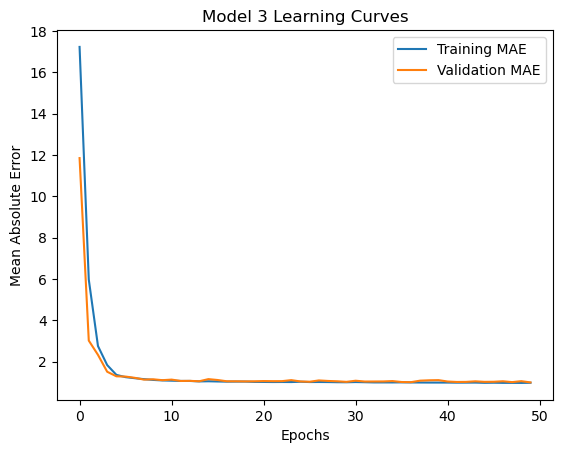

In [11]:
# Model 3: GRU Encoder-Decoder 
def create_encoder_decoder():
    # Encoder
    encoder_inputs = layers.Input(shape=(None, 2))
    encoder_gru1 = layers.GRU(16, activation='relu', return_state=True, return_sequences=True)
    encoder_gru2 = layers.GRU(16, activation='relu', return_state=True)
    encoder_outputs, encoder_state1 = encoder_gru1(encoder_inputs)
    encoder_outputs, encoder_state2 = encoder_gru2(encoder_outputs)
    encoder_states = layers.Concatenate()([encoder_state1, encoder_state2])
    
    # Decoder
    decoder_inputs = layers.Input(shape=(None, 2))
    decoder_gru1 = layers.GRU(32, activation='relu', return_sequences=True, return_state=True)
    decoder_gru2 = layers.GRU(16, activation='relu', return_sequences=True, return_state=True)
    decoder_outputs, _ = decoder_gru1(decoder_inputs, initial_state=encoder_states)
    decoder_outputs, _ = decoder_gru2(decoder_outputs)
    
    # Output
    decoder_dense = layers.Dense(2)
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Model
    model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

def train_encoder_decoder(model, X_train, X_train_decode, y_train, X_val, X_val_decode, y_val, epochs=50):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    history = model.fit([X_train, X_train_decode], y_train, epochs=epochs, batch_size=32,
                        validation_data=([X_val, X_val_decode], y_val), verbose=0)
    return history

# Model 3: input shape (72, 2) -> output shape (12, 2)
# Create and display model 3
model3 = create_encoder_decoder()
model3.summary()

# Train model 13 and plot learning curves
history3 = train_encoder_decoder(model3, X_train, X_train_decode, y_train, X_valid, X_valid_decode, y_valid)
plot_learning_curves(history3, "Model 3")

### Evaluate Model 3
- **Input sequence**: 72 months of minimum and maximum temperatures
- **Decoder input**: 12 months of minimum and maximum temperatures (shifted by 1 month)
- **Output sequence**: 12 months of minimum and maximum temperatures (not teacher forcing)

 Test MAE: 1.07


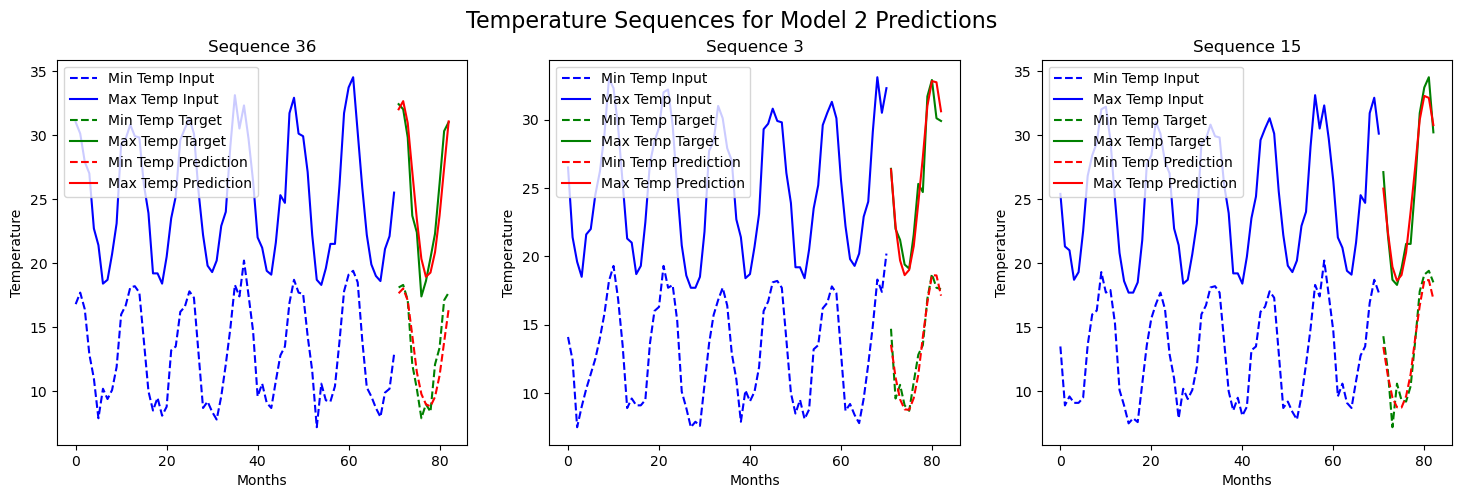

In [12]:
# Predict the next 12 months for model 3
def predict_ed(model, encoder_inputs, decoder_input, outseq_len):
    batch_size = encoder_inputs.shape[0]
    out_dim = decoder_input.shape[-1]
    outseq = np.zeros((batch_size, outseq_len, out_dim))
    decoder_ins = np.zeros((batch_size, outseq_len, out_dim))
    decoder_ins[:, 0, :] = decoder_input
    for t in range(outseq_len):
        pred = model.predict([encoder_inputs, decoder_ins], verbose=0)
        outseq = pred
        if t < outseq_len - 1:
            decoder_ins[:, t+1, :] = pred[:, t, :]
    return outseq

# Evaluate model 3 on the test dataset
y_pred = predict_ed(model3, X_test, X_test_decode[:, 0, :], 12)
mae2 = compute_mae(y_test, y_pred)

# Display 3 random sequences with predictions
sample_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, sample_indices, y_pred, title="Model 2 Predictions")

## (f) Comparison of Models for different Target Lengths

### Train all models for different target lengths
- **Different (input_length, target_length) pairs**: (72, 12), (66, 18), (60, 24), (54, 30), (48, 36)
1. Prepare datasets for each model to handle different target lengths
2. Train each model for 50 epochs
3. Evaluate each model for target lengths of months
4. Store MAE for each model and target length

In [13]:
settings = [(72, 12), (66, 18), (60, 24), (54, 30), (48, 36)]
model_maes = {
    'Model 1': [],
    'Model 2': [],
    'Model 3': []
}

for input_length, target_length in settings:
    # Prepare datasets for the current setting
    train_ds = split_data_length(PerthA_df, (input_length, target_length), train=True)
    val_ds = split_data_length(PerthM_val, (input_length, target_length))
    test_ds = split_data_length(PerthM_test, (input_length, target_length))
    train_ds_output1 = split_data_length(PerthA_df, (input_length, 1), train=True)
    val_ds_output1 = split_data_length(PerthM_val, (input_length, 1))

    print(f"\nSetting: ({input_length}, {target_length})")

    # Train and evaluate Model 1
    model_1 = create_gru((input_length, 2), (target_length, 2))
    train_model(model_1, train_ds, val_ds)
    mae_1 = evaluate_model1(model_1, test_ds)
    model_maes['Model 1'].append(mae_1)

    # Train and evaluate Model 2
    model_2 = create_gru((input_length, 2), (1, 2))
    train_model(model_2, train_ds_output1, val_ds_output1)
    for batch in test_ds.take(1):
        X_test, y_test = batch
        y_pred = predict_months(model_2, X_test, steps=target_length)
    mae_2 = compute_mae(y_test, y_pred, "Model 2")
    model_maes['Model 2'].append(mae_2)

    # Train and evaluate Model 3
    X_train, X_train_decode, y_train = split_XY_from_dataset(train_ds)
    X_valid, X_valid_decode, y_valid = split_XY_from_dataset(val_ds)
    X_test, X_test_decode, y_test = split_XY_from_dataset(test_ds)
    model_3 = create_encoder_decoder()
    train_encoder_decoder(model_3, X_train, X_train_decode, y_train, X_valid, X_valid_decode, y_valid)
    y_pred = predict_ed(model_3, X_test, X_test_decode[:, 0, :], target_length)
    mae_3 = compute_mae(y_test, y_pred, "Model 3")
    model_maes['Model 3'].append(mae_3)


Setting: (72, 12)
Model 1 Test MAE: 1.32
Model 2 Test MAE: 1.26
Model 3 Test MAE: 1.20

Setting: (66, 18)
Model 1 Test MAE: 1.29
Model 2 Test MAE: 1.19
Model 3 Test MAE: 1.13

Setting: (60, 24)
Model 1 Test MAE: 1.18
Model 2 Test MAE: 1.17
Model 3 Test MAE: 1.21

Setting: (54, 30)
Model 1 Test MAE: 1.23
Model 2 Test MAE: 1.08
Model 3 Test MAE: 1.03

Setting: (48, 36)
Model 1 Test MAE: 1.48
Model 2 Test MAE: 1.23
Model 3 Test MAE: 1.02


### Plot MAE against target lengths for all models

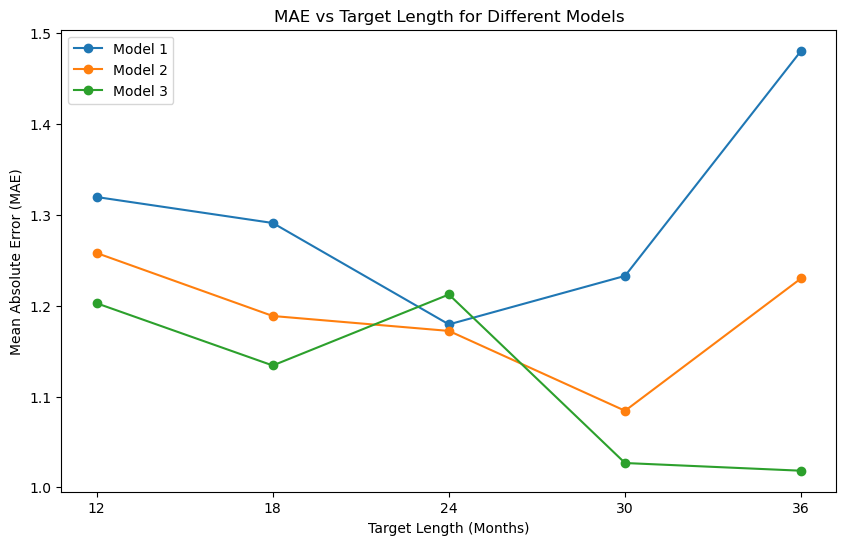

In [14]:
plt.figure(figsize=(10, 6))
for model, maes in model_maes.items():
    plt.plot([length[1] for length in settings], maes, marker='o', label=model)
plt.title('MAE vs Target Length for Different Models')
plt.xlabel('Target Length (Months)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks([length[1] for length in settings])
plt.legend()
plt.show()

### Analysis

**Which model deteriorates the fastest?** 

Model 3 deteriorates the fastest, as the test MAE remains relatively stable until the last setting, where it jumps significantly from 1.08 in the (54, 30) setting to 1.57 in the (48, 36) setting. This is likely due to the model's inability to predict the target sequence accurately when the target length is almost as long as the input sequence, as the model is not able to learn the patterns effectively with less training input data.

**How good/bad are these models in learning the temperature patterns from one weather station to predict the temperatures in another weather station?**

#### Table of each model MAE on test dataset for settings (input_length, target_length)

| Setting | Model 1 MAE | Model 2 MAE | Model 3 MAE |
| --- | --- | --- | --- |
| (72, 12) |  |  |  |
| (66, 18) |  |  |  |
| (60, 24) |  |  |  |
| (54, 30) |  |  |  |
| (48, 36) |  |  |  |

# Part 2 Tasks
Train a variational autoencoder (VAE) to synthesize temperature data.

## Prepare Data for VAE Model

In [29]:
# Get max temperatures sequences
def get_max_temps(df, seq_length=84):
    max_temp = df['Mean maximum temperature (°C)'].values
    sequences = []
    for i in range(len(max_temp) - seq_length + 1):
        sequences.append(max_temp[i:i + seq_length])
    sequences = np.array(sequences)
    return sequences

# Get the max temperature sequences
X_train = get_max_temps(PerthA_df)
X_valid = get_max_temps(PerthM_val)
print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")

X_train shape: (880, 84)
X_valid shape: (157, 84)


## Train VAE model
- **Input sequence**: 84 months of maximum temperatures

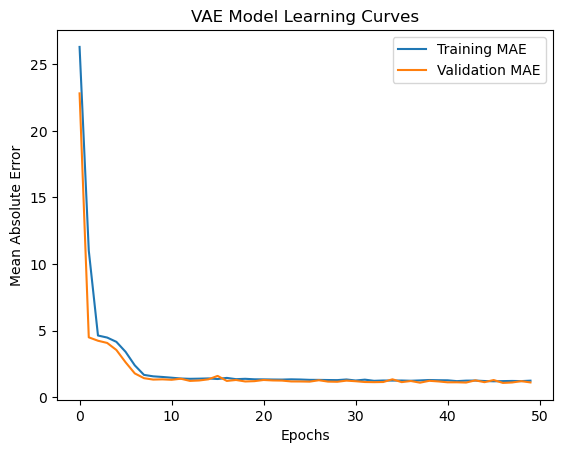

In [32]:
# Define a customised layer
class Sampling(tf.keras.Layer):
    def call(self, inputs):
        mean, logvar = inputs
        # Define the latent loss and add it to the loss function
        latent_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.exp(logvar) - tf.square(mean), axis=-1) / 784.
        self.add_loss(latent_loss)
        return tf.random.normal(tf.shape(logvar)) * tf.exp(logvar / 2) + mean

# Variational Autoencoder (VAE) model
def create_vae(input_shape, codings_size):
    # Encoder part of the VAE
    inputs = layers.Input(shape=input_shape)
    Z = layers.Flatten()(inputs)
    Z = layers.Dense(150, activation="relu")(inputs)
    Z = layers.Dense(100, activation="relu")(Z)
    codings_mean = layers.Dense(codings_size)(Z) # mu
    codings_log_var = layers.Dense(codings_size)(Z) # gamma
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = tf.keras.Model(inputs=inputs, outputs=[codings_mean, codings_log_var, codings])

    # Decoder part of the VAE
    decoder_inputs = tf.keras.Input(shape=[codings_size])
    x = layers.Dense(100, activation="relu")(decoder_inputs)
    x = layers.Dense(150, activation="relu")(x)
    x = layers.Dense(input_shape[0])(x)
    outputs = layers.Reshape(input_shape)(x)
    variational_decoder = tf.keras.Model(inputs=decoder_inputs, outputs=outputs)

    # Join encoder and decoder together to form VAE
    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(codings)
    variational_ae = tf.keras.Model(inputs=inputs, outputs=reconstructions)

    return variational_ae, variational_encoder, variational_decoder

# Create the VAE model
codings_size = 5
vae, vae_encoder, vae_decoder = create_vae(input_shape=(84,), codings_size=codings_size)

# Train the VAE model
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
vae.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
history = vae.fit(X_train, X_train, validation_data=(X_valid, X_valid), 
                  epochs=50, batch_size=32, verbose=0)
plot_learning_curves(history, "VAE Model")

# Report the mean and logarithmic variance of the learned distribution
# mean = vae_encoder(X_train)[0]
# logvar = vae_encoder(X_train)[1]
# mean = round(tf.reduce_mean(mean),3)
# logvar = round(tf.reduce_mean(logvar),3)
# print(f"Mean: {mean.numpy()}")
# print(f"Logarithmic Variance: {logvar.numpy()}")

## Synthesise temperature sequences

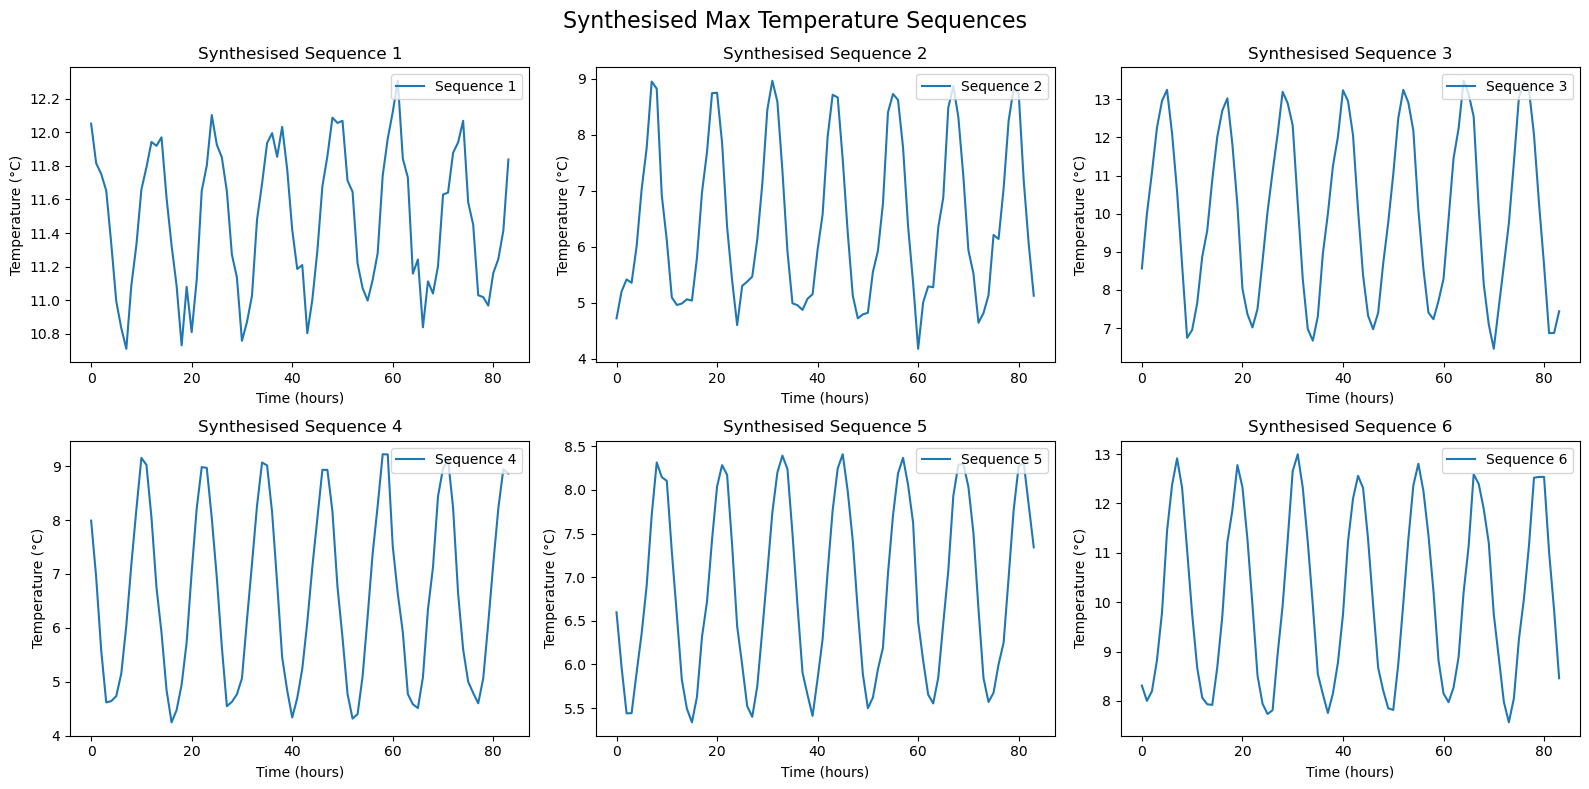

In [35]:
# Function to plot the synthesised sequences
def plot_synthesised_sequences(sequences, num_cols=3):
    num_rows = len(sequences) // num_cols + (len(sequences) % num_cols > 0)
    plt.figure(figsize=(16, 8))
    
    for i, seq in enumerate(sequences):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(seq, label=f'Sequence {i + 1}')
        plt.title(f'Synthesised Sequence {i + 1}')
        plt.xlabel('Time (hours)')
        plt.ylabel('Temperature (°C)')
        plt.suptitle('Synthesised Max Temperature Sequences', fontsize=16)
        plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.5)
    
    plt.tight_layout()
    plt.show()

# Generate synthetic max temperature sequences
num_samples = 6
codings = tf.random.normal(shape=(num_samples, codings_size))
synthetic_max_temps = vae_decoder.predict(codings, verbose=0)
plot_synthesised_sequences(synthetic_max_temps)